In [1]:
from scipy.optimize import minimize
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
import warnings
warnings.filterwarnings("ignore")
import yfinance as yf

/tmp/ipykernel_199/2773345201.py:5: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


In [2]:
!pip install yfinance

In [2]:
# Importation of data
list_tickers = ["META", "NFLX", "TSLA"]
database = yf.download(list_tickers)

# Take only the adjusted stock price
database = database["Adj Close"]

# Drop missing values
data = database.dropna().pct_change(1).dropna()

[*********************100%***********************]  3 of 3 completed


In [3]:
def MV_criterion(weights, data):
    """
    -----------------------------------------------------------------------------
    | Output: optimization porfolio criterion                                   |
    -----------------------------------------------------------------------------
    | Inputs: -weight (type ndarray numpy): Wheight for portfolio               |
    |         -data (type ndarray numpy): Returns of stocks                     |
    -----------------------------------------------------------------------------
    """

    # Parameters
    Lambda = 3
    W = 1
    Wbar = 1 + 0.25 / 100

    # Compute portfolio returns
    portfolio_return = np.multiply(data, np.transpose(weights))
    portfolio_return = portfolio_return.sum(axis=1)

    # Compute mean and volatility of the portfolio
    mean = np.mean(portfolio_return, axis=0)
    std = np.std(portfolio_return, axis=0)

    # Compute the criterion
    criterion = Wbar ** (1 - Lambda) / (1 + Lambda) + Wbar ** (-Lambda) \
                * W * mean - Lambda / 2 * Wbar ** (-1 - Lambda) * W ** 2 * std ** 2
    criterion = -criterion
    
    return criterion

In [4]:
# Define train and test sets
split = int(0.7 * len(data))
train_set = data.iloc[:split, :]
test_set = data.iloc[split:, :]

# Find the number of asset
n = data.shape[1]

# Initialisation weight value
x0 = np.ones(n)

# Optimization constraints problem
cons = ({'type': 'eq', 'fun': lambda x: sum(abs(x)) - 1})

# Set the bounds
Bounds = [(0, 1) for i in range(0, n)]

# Optimization problem solving
res_MV = minimize(MV_criterion, x0, method="SLSQP",
                  args=(train_set), bounds=Bounds,
                  constraints=cons, options={'disp': True})

# Result for computations
X_MV = res_MV.x

Optimization terminated successfully    (Exit mode 0)
            Current function value: -0.24980925386923003
            Iterations: 2
            Function evaluations: 8
            Gradient evaluations: 2


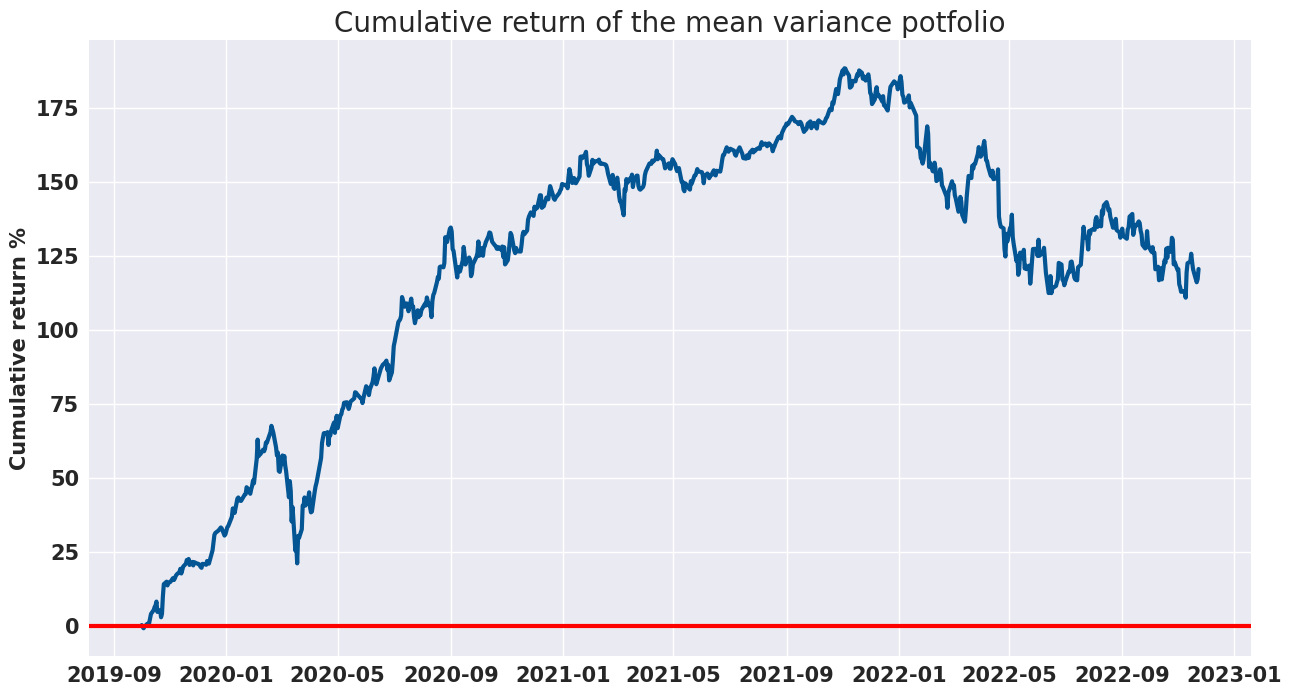

In [5]:
# Compute the cumulative return of the portfolio (CM)
portfolio_return_MV = np.multiply(test_set,np.transpose(X_MV))
portfolio_return_MV = portfolio_return_MV.sum(axis=1)

# Plot the CM
plt.figure(figsize=(15,8))
plt.plot(np.cumsum(portfolio_return_MV)*100, color="#035593", linewidth=3)
plt.ylabel("Cumulative return %", size=15, fontweight="bold")
plt.xticks(size=15,fontweight="bold")
plt.yticks(size=15,fontweight="bold")
plt.title("Cumulative return of the mean variance potfolio", size=20)
plt.axhline(0, color="r",linewidth=3)
plt.show()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

    -----------------------------------------------------------------------------
    Portfolio: ['META', 'NFLX', 'TSLA']
    -----------------------------------------------------------------------------
    Beta: 1.216 	 Alpha: 22.87 %	     Sharpe: 0.866 	 Sortino: 1.119
    -----------------------------------------------------------------------------
    VaR: 65.01 %	 cVaR: 80.24 % 	     VaR/cVaR: 1.234 	 drawdown: 59.99 %
    -----------------------------------------------------------------------------
    


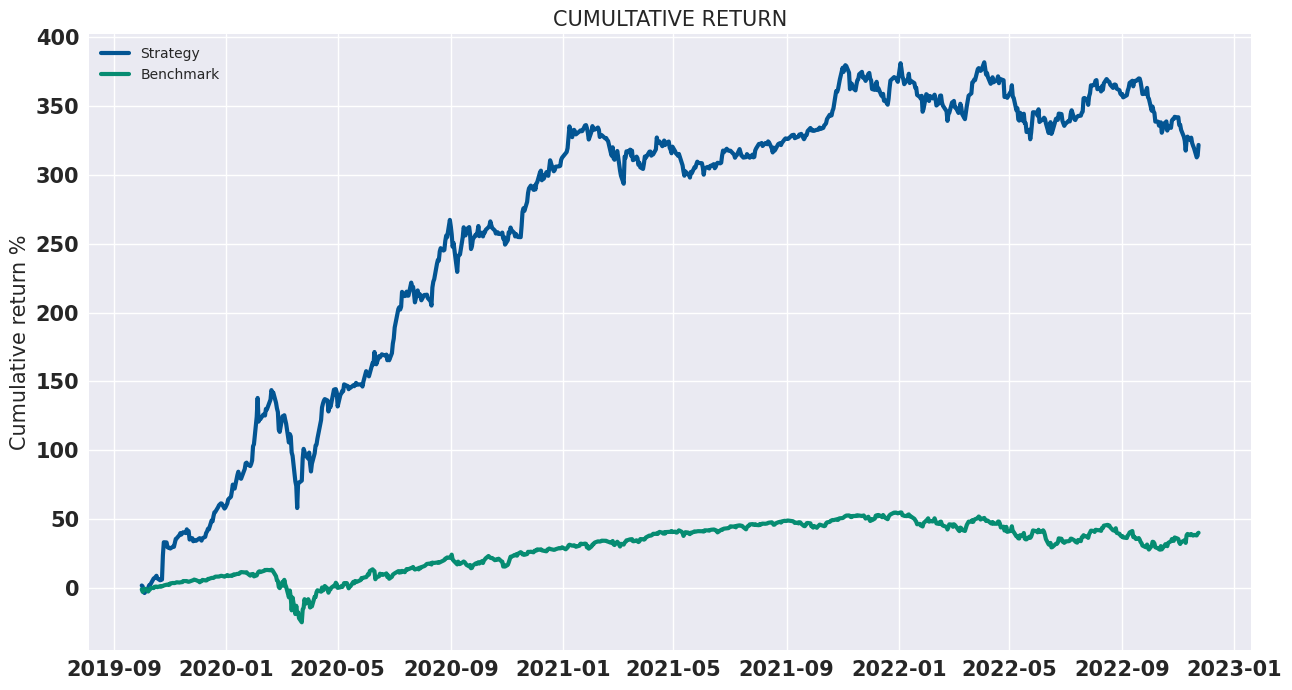

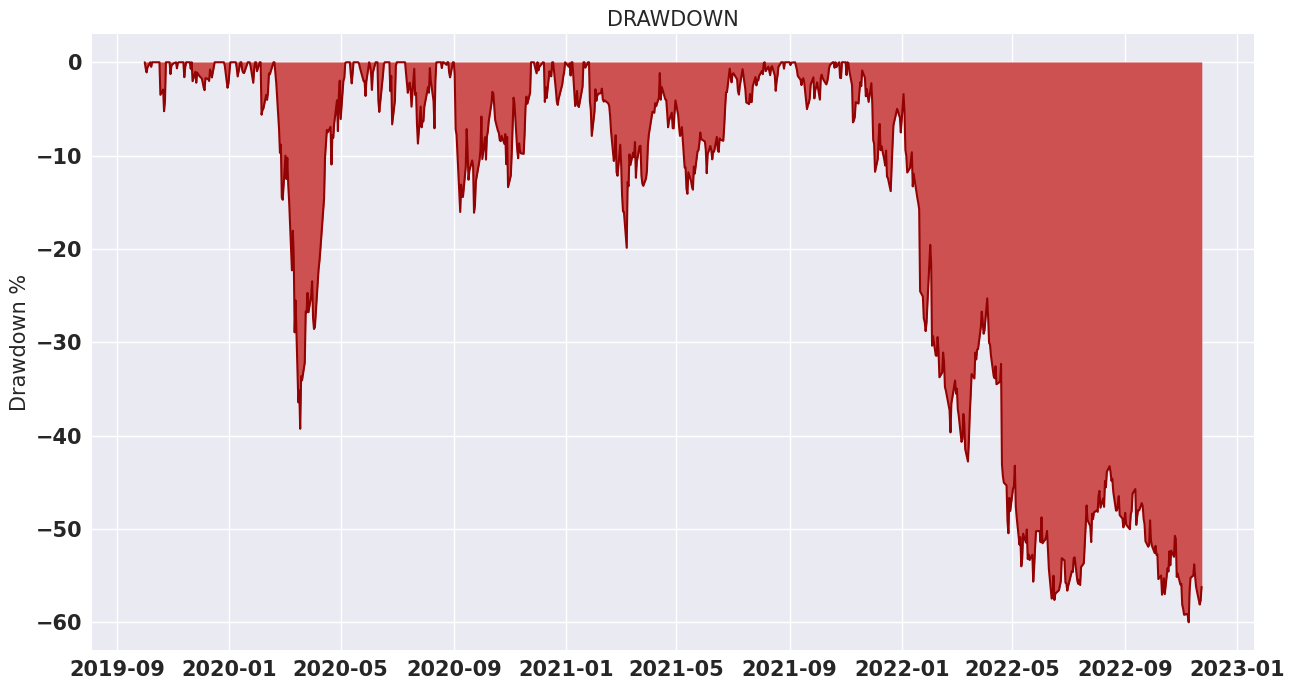

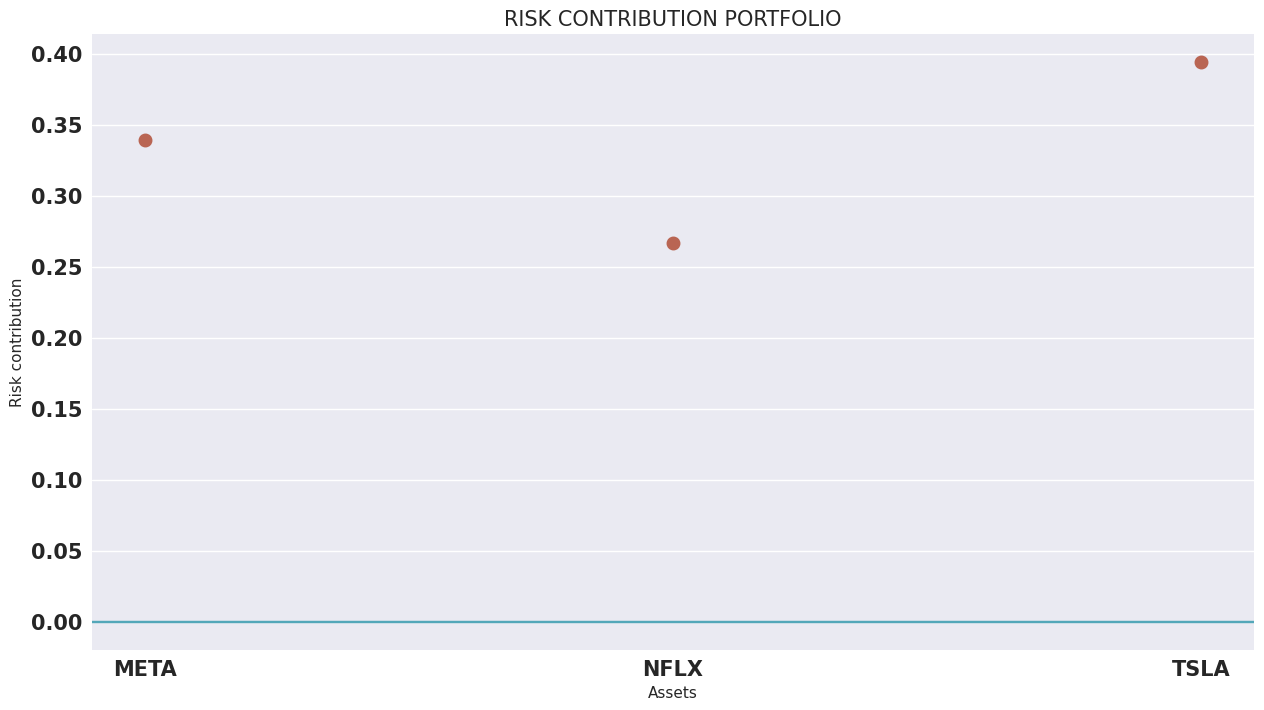

In [8]:
# Code from chapter 5
from Backtest import *
backtest_static_portfolio(X_MV, test_set, CR=True)

In [9]:
def SK_criterion(weights, data):
    """ 
    -----------------------------------------------------------------------------
    | Output: optimization porfolio criterion                                   |
    -----------------------------------------------------------------------------
    | Inputs: -weight (type ndarray numpy): Wheight for portfolio               |
    |         -data (type ndarray numpy): Returns of stocks                     |
    -----------------------------------------------------------------------------
    """
    from scipy.stats import skew, kurtosis
    # Parameters
    Lambda = 3
    W = 1
    Wbar = 1 + 0.25 / 100

    # Compute portfolio returns
    portfolio_return = np.multiply(data, np.transpose(weights))
    portfolio_return = portfolio_return.sum(axis=1)

    # Compute mean, volatility, skew, kurtosis of the portfolio
    mean = np.mean(portfolio_return, axis=0)
    std = np.std(portfolio_return, axis=0)
    skewness = skew(portfolio_return, 0)
    kurt = kurtosis(portfolio_return, 0)

    # Compute the criterion
    criterion = Wbar ** (1 - Lambda) / (1 + Lambda) + Wbar ** (-Lambda) \
    * W * mean - Lambda / 2 * Wbar ** (-1 - Lambda) * W ** 2 * std ** 2 \
    + Lambda * (Lambda + 1) / (6) * Wbar ** (-2 - Lambda) * W ** 3 * skewness \
    - Lambda * (Lambda + 1) * (Lambda + 2) / (24) * Wbar ** (-3 - Lambda) *\
     W ** 4 * kurt
    
    criterion = -criterion
    
    return criterion

In [10]:
# Find the number of asset
n = data.shape[1]

# Initialization weight value
x0 = np.ones(n)

# Optimization constraints problem
cons = ({'type': 'eq', 'fun': lambda x: sum(abs(x)) - 1})

# Set the bounds
Bounds = [(0, 1) for i in range(0, n)]

# Optimization problem solving
res_SK = minimize(SK_criterion, x0, method="SLSQP",
                  args=(train_set), bounds=Bounds,
                  constraints=cons, options={'disp': True})

# Result 
X_SK = res_SK.x

Optimization terminated successfully    (Exit mode 0)
            Current function value: 6.06953490696863
            Iterations: 12
            Function evaluations: 57
            Gradient evaluations: 12


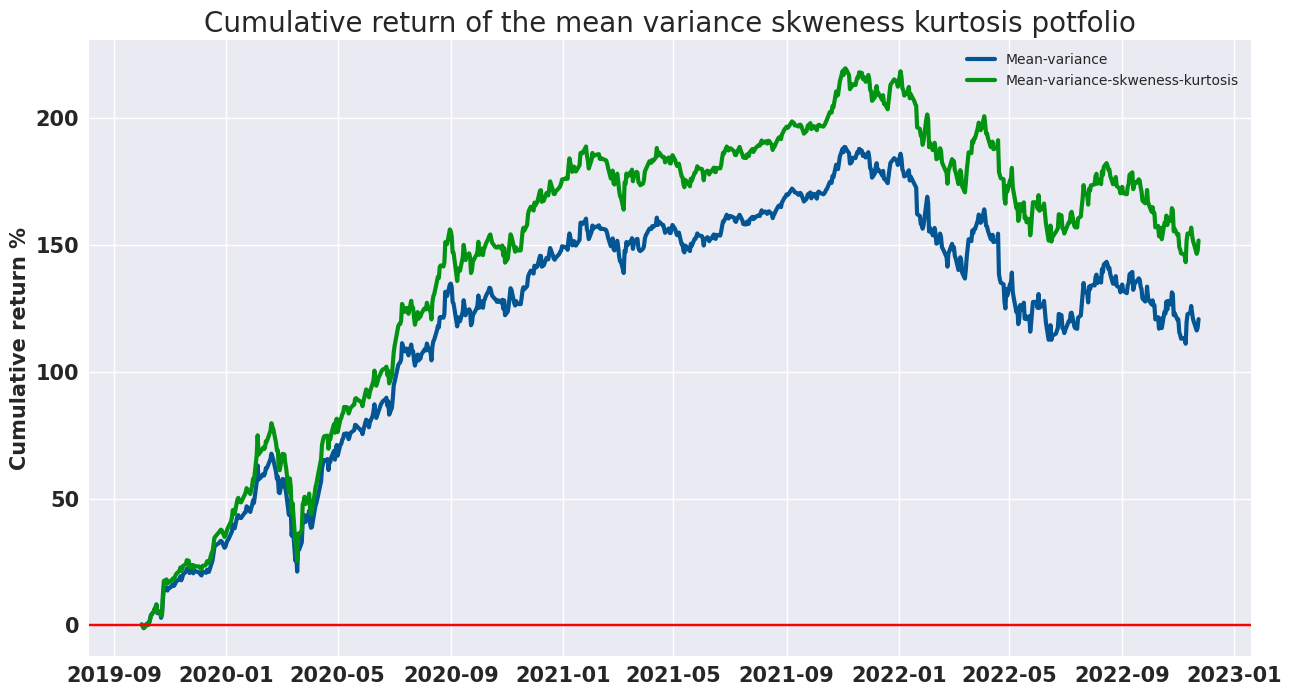

In [11]:
# Compute the cumulative return of the portfolio (CM)
portfolio_return_SK = np.multiply(test_set,np.transpose(X_SK))
portfolio_return_SK = portfolio_return_SK.sum(axis=1)

# Plot the CM
fig = plt.figure(figsize=(15,8))
plt.plot(np.cumsum(portfolio_return_MV)*100, color="#035593", linewidth=3)
plt.plot(np.cumsum(portfolio_return_SK)*100, color="#039313", linewidth=3)
plt.ylabel("Cumulative return %", size=15, fontweight="bold")
plt.axhline(0, color="r")
plt.legend(["Mean-variance", "Mean-variance-skweness-kurtosis"])
plt.title("Cumulative return of the mean variance skweness kurtosis potfolio", size=20)
plt.xticks(size=15, fontweight="bold")
plt.yticks(size=15, fontweight="bold")
plt.show()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

    -----------------------------------------------------------------------------
    Portfolio: ['META', 'NFLX', 'TSLA']
    -----------------------------------------------------------------------------
    Beta: 1.27 	 Alpha: 32.01 %	     Sharpe: 1.027 	 Sortino: 1.367
    -----------------------------------------------------------------------------
    VaR: 62.06 %	 cVaR: 78.35 % 	     VaR/cVaR: 1.263 	 drawdown: 59.46 %
    -----------------------------------------------------------------------------
    


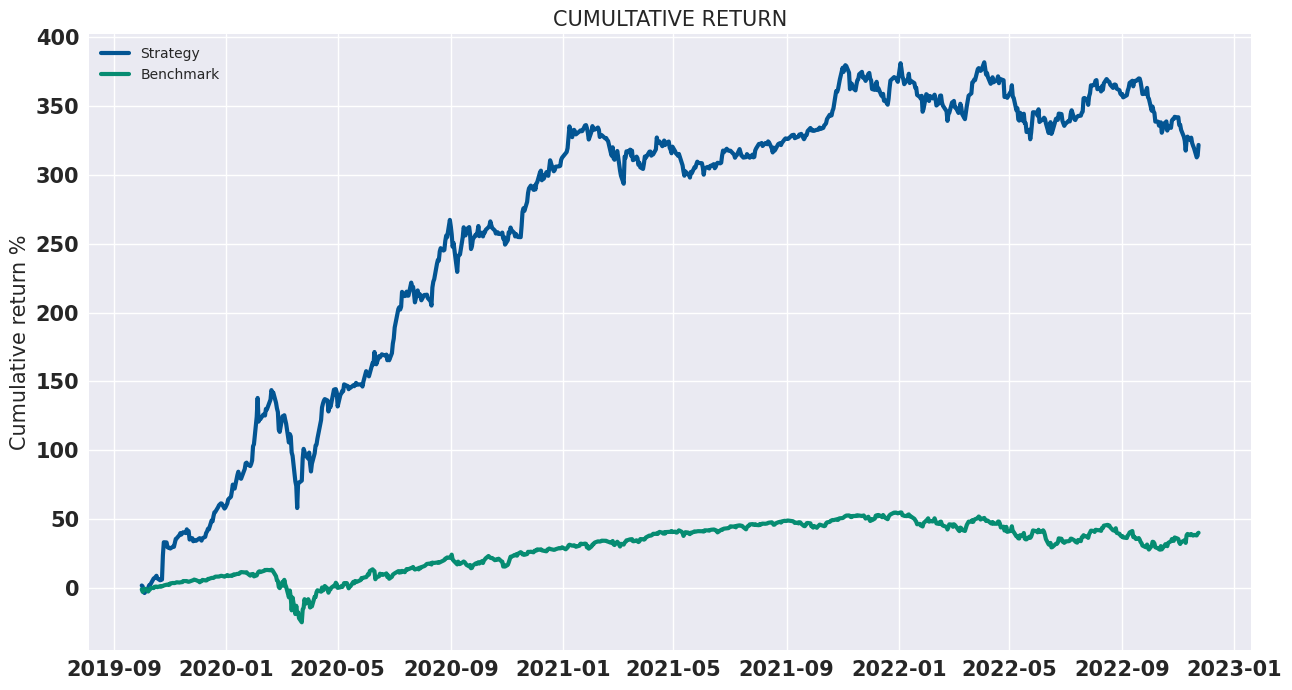

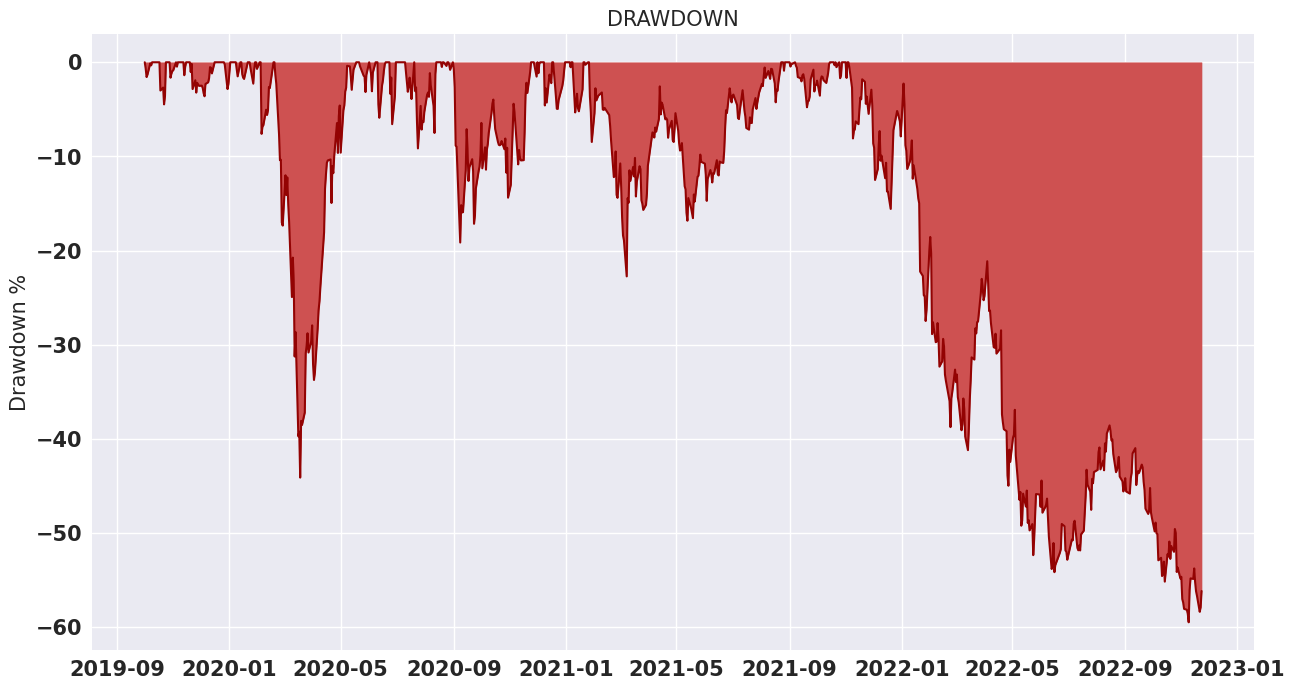

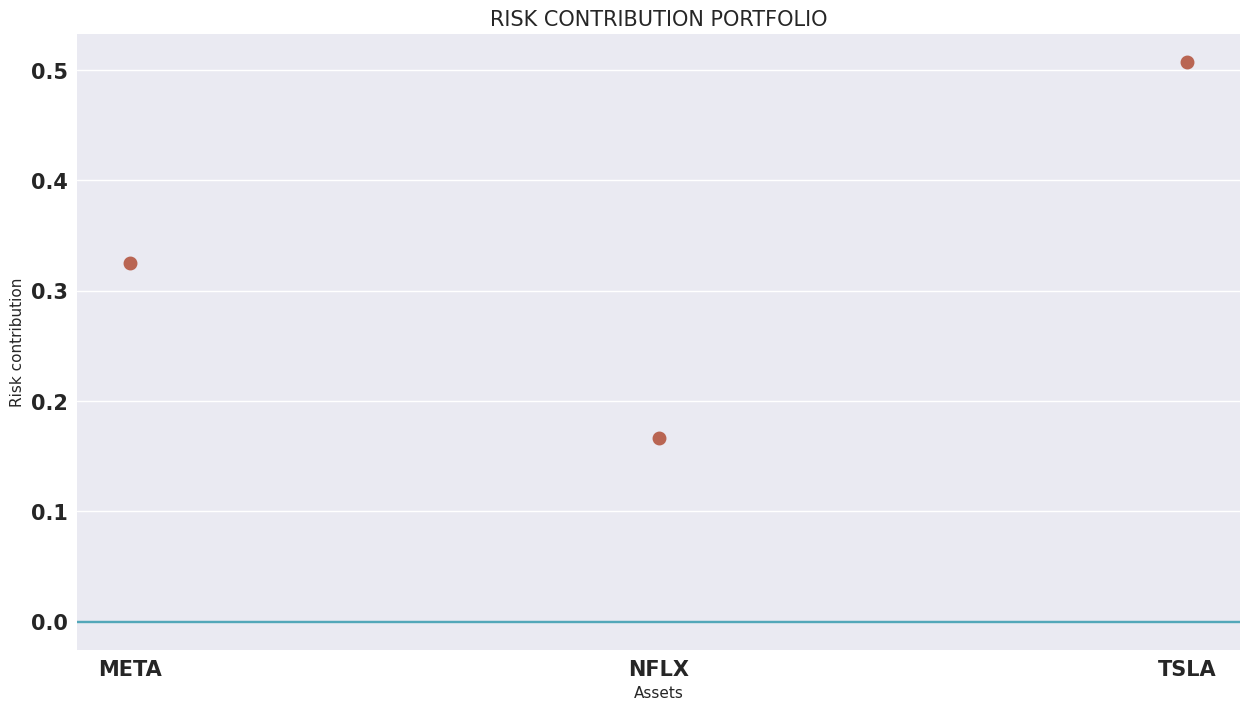

In [12]:
backtest_static_portfolio(X_SK, test_set, CR=True)